# DAS Earthquake Data Processing Script
### Reproducing Figure 2c from Lindsey et al., 2019, *Science*
# Citation:  
### Nathaniel J. Lindsey et al. ,Illuminating seafloor faults and ocean dynamics with dark fiber distributed acoustic sensing.Science366,1103-1107(2019).DOI:10.1126/science.aay5881
### Created by Yusong Yuan, 12/16/2025

In [171]:
import obspy
import numpy as np
import matplotlib.pyplot as plt

In [172]:
# 读取 mseed 文件
st = obspy.read("../Cheng_et_al2021//EQ/event_4000_5999.mseed")
#st = obspy.read("../Cheng_et_al2021//EQ/event_2000_3999.mseed")
delta = st[0].stats.delta
npts = st[0].stats.npts
taxis = np.arange(0, delta*npts, delta)


tmin, tmax = 10, 13
time_mask = (taxis >= tmin) & (taxis <= tmax) 

xmin,xmax = 8, 12

wfs = []
channels = []
# 遍历每个通道（Trace）
for tr in st:
    loc = int(tr.stats.station)*0.002
    if loc<xmin or loc>xmax+0.2:
        continue
    tr.taper(max_percentage=0.05) 

    wf = tr.data[time_mask]
    wf/np.max(np.abs(wf))
    wfs.append(wf)
    channels.append(loc)

wfs_arr = np.array(wfs)
channels = np.array(channels)


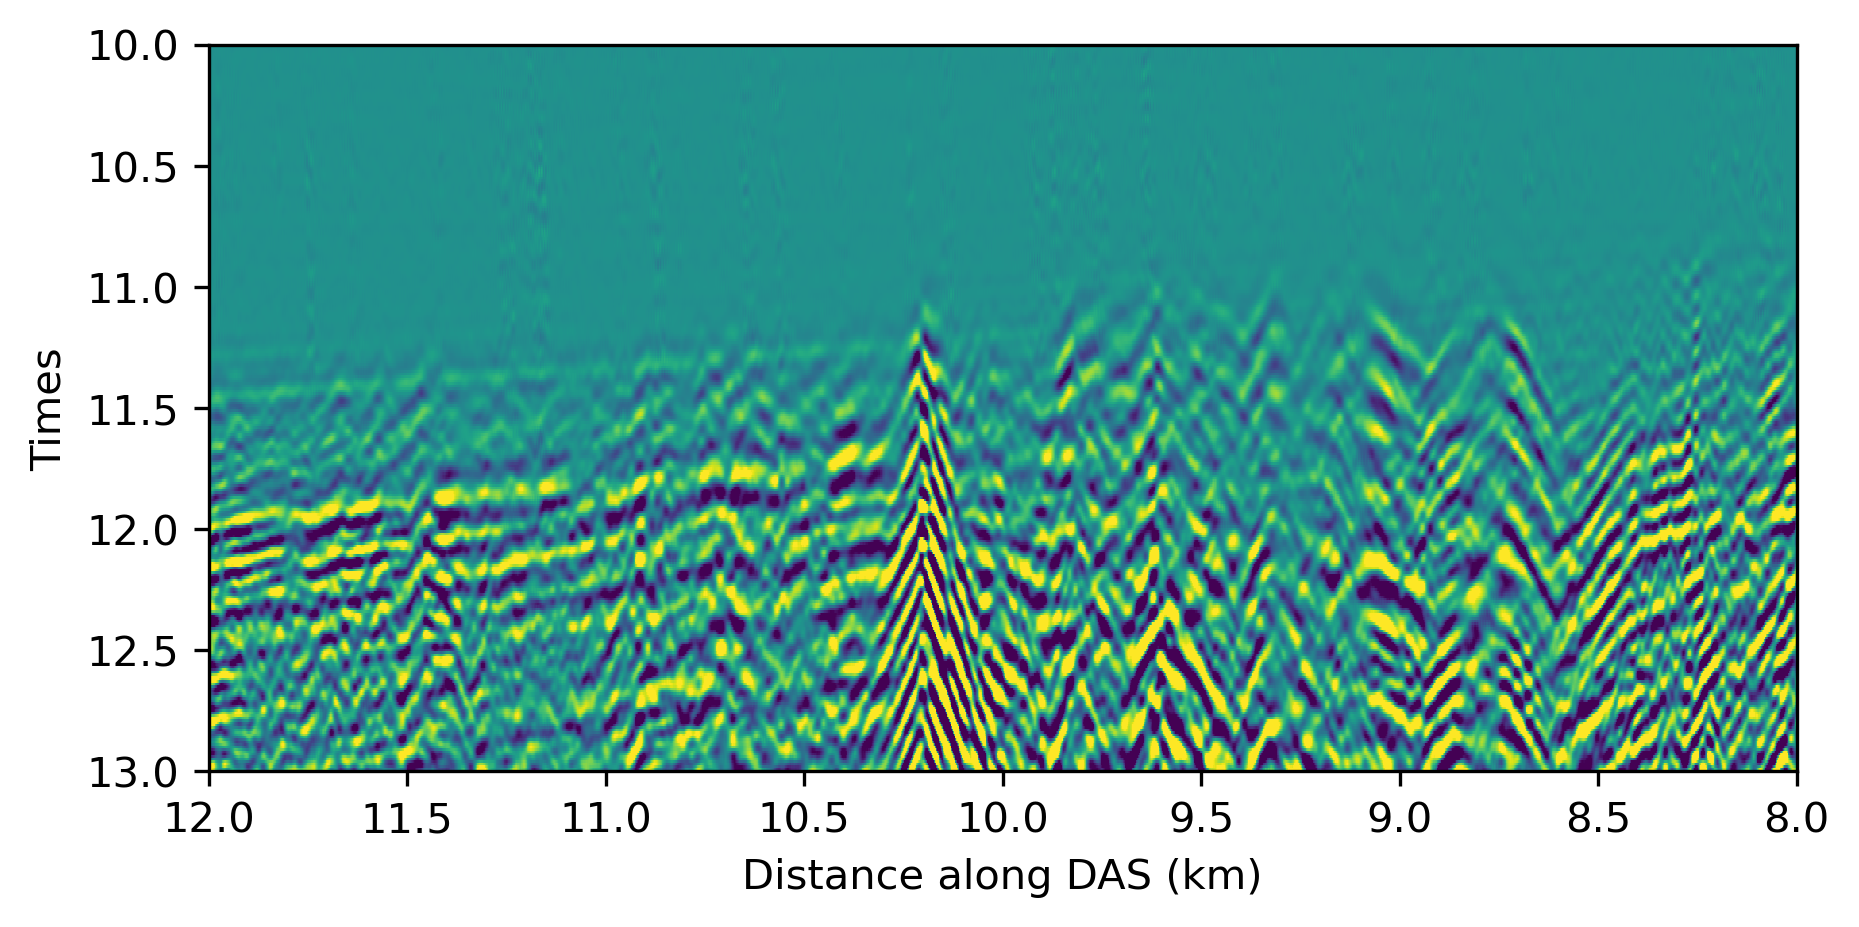

In [173]:
from scipy.fft import fft, ifft, fftfreq
from scipy.ndimage import uniform_filter1d 

# 参数设置
sampling_rate = 1 / (st[0].stats.delta)  # 采样率，从波形数据的采样间隔获取
dx = 2  # 通道间距 2 米
f_min = 1.  # 最小频率 1 Hz
f_max = 30  # 最大频率 30 Hz
k_min = -0.03  # 最小波数
k_max = 0.03  # 最大波数
window_size = 1  # 平滑窗口大小

# 对波形数据进行平滑
wfs_smooth = uniform_filter1d(wfs_arr, size=window_size, axis=0)

# 获取数据的频率和波数
n_samples, n_channels = wfs_smooth.shape
frequencies = fftfreq(n_samples, d=st[0].stats.delta)  # 频率轴
wavenumbers = fftfreq(n_channels, d=dx)  # 波数轴

# 创建频率和波数的滤波器
# 1. 应用频率滤波 (1-30 Hz)
freq_mask = (frequencies >= f_min) & (frequencies <= f_max)

# 2. 应用波数滤波 (k = 0 ± 0.03 m−1)
k_mask = (np.abs(wavenumbers) <= k_max) & (np.abs(wavenumbers) >= k_min)

# 3. 创建余弦加窗（分别为频率和波数加窗）
# 频率加窗
freq_window = np.cos(np.pi * (frequencies - f_min) / (f_max - f_min))
freq_window[freq_window < 0] = 0  # 确保余弦窗没有负值

# 波数加窗
k_window = np.cos(np.pi * (np.abs(wavenumbers) - k_min) / (k_max - k_min))
k_window[k_window < 0] = 0  # 确保余弦窗没有负值

# 4. 对波形数据进行傅里叶变换
wfs_fft = fft(wfs_smooth, axis=0)  # 对每个通道的波形进行傅里叶变换

# 5. 应用频率和波数滤波器
# 对频率方向应用频率窗，对波数方向应用波数窗
wfs_fft_filtered = np.copy(wfs_fft)
for i in range(n_channels):  # 遍历每个通道
    # 对频率进行加窗
    wfs_fft_filtered[:, i] = wfs_fft[:, i] * freq_window
    # 对波数进行加窗
    wfs_fft_filtered[i, :] = wfs_fft_filtered[i, :] * k_window

# 6. 逆傅里叶变换以恢复数据
wfs_filtered = ifft(wfs_fft_filtered, axis=0).real  # 获取实部

# # 创建一个绘图窗口
plt.figure(figsize=(6, 3),dpi=300)
X, Y = np.meshgrid(channels, taxis[time_mask])

# 绘制滤波后的波形
pcm = plt.pcolormesh(X, Y, wfs_filtered.T / np.max(np.abs(wfs_filtered)), shading='auto', vmin=-0.2, vmax=0.2)
plt.tight_layout()  # 调整布局
plt.xlim(xmax, xmin)  # 设置 x 轴范围
plt.ylim(tmax, tmin)  # 设置 y 轴范围
plt.ylabel("Times")
plt.xlabel("Distance along DAS (km)")
plt.show()